# Project: Identify Customer Segments

In this project, you will apply unsupervised learning techniques to identify segments of the population that form the core customer base for a mail-order sales company in Germany. These segments can then be used to direct marketing campaigns towards audiences that will have the highest expected rate of returns. The data that you will use has been provided by our partners at Bertelsmann Arvato Analytics, and represents a real-life data science task.

This notebook will help you complete this task by providing a framework within which you will perform your analysis steps. In each step of the project, you will see some text describing the subtask that you will perform, followed by one or more code cells for you to complete your work. **Feel free to add additional code and markdown cells as you go along so that you can explore everything in precise chunks.** The code cells provided in the base template will outline only the major tasks, and will usually not be enough to cover all of the minor tasks that comprise it.

It should be noted that while there will be precise guidelines on how you should handle certain tasks in the project, there will also be places where an exact specification is not provided. **There will be times in the project where you will need to make and justify your own decisions on how to treat the data.** These are places where there may not be only one way to handle the data. In real-life tasks, there may be many valid ways to approach an analysis task. One of the most important things you can do is clearly document your approach so that other scientists can understand the decisions you've made.

At the end of most sections, there will be a Markdown cell labeled **Discussion**. In these cells, you will report your findings for the completed section, as well as document the decisions that you made in your approach to each subtask. **Your project will be evaluated not just on the code used to complete the tasks outlined, but also your communication about your observations and conclusions at each stage.**

In [145]:
# import libraries here; add more as necessary
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import json

from sklearn.decomposition import PCA, FastICA
from sklearn.preprocessing import StandardScaler, OneHotEncoder, Imputer
from sklearn.cluster import KMeans

# magic word for producing visualizations in notebook
%matplotlib inline

### Step 0: Load the Data

There are four files associated with this project (not including this one):

- `Udacity_AZDIAS_Subset.csv`: Demographics data for the general population of Germany; 891211 persons (rows) x 85 features (columns).
- `Udacity_CUSTOMERS_Subset.csv`: Demographics data for customers of a mail-order company; 191652 persons (rows) x 85 features (columns).
- `Data_Dictionary.md`: Detailed information file about the features in the provided datasets.
- `AZDIAS_Feature_Summary.csv`: Summary of feature attributes for demographics data; 85 features (rows) x 4 columns

Each row of the demographics files represents a single person, but also includes information outside of individuals, including information about their household, building, and neighborhood. You will use this information to cluster the general population into groups with similar demographic properties. Then, you will see how the people in the customers dataset fit into those created clusters. The hope here is that certain clusters are over-represented in the customers data, as compared to the general population; those over-represented clusters will be assumed to be part of the core userbase. This information can then be used for further applications, such as targeting for a marketing campaign.

To start off with, load in the demographics data for the general population into a pandas DataFrame, and do the same for the feature attributes summary. Note for all of the `.csv` data files in this project: they're semicolon (`;`) delimited, so you'll need an additional argument in your [`read_csv()`](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.read_csv.html) call to read in the data properly. Also, considering the size of the main dataset, it may take some time for it to load completely.

Once the dataset is loaded, it's recommended that you take a little bit of time just browsing the general structure of the dataset and feature summary file. You'll be getting deep into the innards of the cleaning in the first major step of the project, so gaining some general familiarity can help you get your bearings.

In [146]:
# Load in the general demographics data.
azdias = pd.read_csv("Udacity_AZDIAS_Subset.csv", delimiter=';')

# Load in the feature summary file.
feat_info = pd.read_csv('AZDIAS_Feature_Summary.csv', delimiter=';')

In [4]:
feat_info.head()

,attribute,information_level,type,missing_or_unknown
0,AGER_TYP,person,categorical,"[-1,0]"
1,ALTERSKATEGORIE_GROB,person,ordinal,"[-1,0,9]"
2,ANREDE_KZ,person,categorical,"[-1,0]"
3,CJT_GESAMTTYP,person,categorical,[0]
4,FINANZ_MINIMALIST,person,ordinal,[-1]


In [5]:
azdias.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891221 entries, 0 to 891220
Data columns (total 85 columns):
AGER_TYP                 891221 non-null int64
ALTERSKATEGORIE_GROB     891221 non-null int64
ANREDE_KZ                891221 non-null int64
CJT_GESAMTTYP            886367 non-null float64
FINANZ_MINIMALIST        891221 non-null int64
FINANZ_SPARER            891221 non-null int64
FINANZ_VORSORGER         891221 non-null int64
FINANZ_ANLEGER           891221 non-null int64
FINANZ_UNAUFFAELLIGER    891221 non-null int64
FINANZ_HAUSBAUER         891221 non-null int64
FINANZTYP                891221 non-null int64
GEBURTSJAHR              891221 non-null int64
GFK_URLAUBERTYP          886367 non-null float64
GREEN_AVANTGARDE         891221 non-null int64
HEALTH_TYP               891221 non-null int64
LP_LEBENSPHASE_FEIN      886367 non-null float64
LP_LEBENSPHASE_GROB      886367 non-null float64
LP_FAMILIE_FEIN          886367 non-null float64
LP_FAMILIE_GROB          886367 n

In [6]:
azdias.head()

,AGER_TYP,ALTERSKATEGORIE_GROB,ANREDE_KZ,CJT_GESAMTTYP,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,...,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB
0,-1,2,1,2.0,3,4,3,5,5,3,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,-1,1,2,5.0,1,5,2,5,4,5,...,2.0,3.0,2.0,1.0,1.0,5.0,4.0,3.0,5.0,4.0
2,-1,3,2,3.0,1,4,1,2,3,5,...,3.0,3.0,1.0,0.0,1.0,4.0,4.0,3.0,5.0,2.0
3,2,4,2,2.0,4,2,5,2,1,2,...,2.0,2.0,2.0,0.0,1.0,3.0,4.0,2.0,3.0,3.0
4,-1,3,1,5.0,4,3,4,1,3,2,...,2.0,4.0,2.0,1.0,2.0,3.0,3.0,4.0,6.0,5.0


In [7]:
azdias.tail()

,AGER_TYP,ALTERSKATEGORIE_GROB,ANREDE_KZ,CJT_GESAMTTYP,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,...,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB
891216,-1,3,2,5.0,1,4,2,5,4,4,...,3.0,2.0,0.0,0.0,1.0,2.0,3.0,NaN,NaN,NaN
891217,-1,2,1,4.0,3,3,3,2,2,3,...,1.0,3.0,3.0,2.0,4.0,5.0,3.0,4.0,6.0,5.0
891218,-1,2,2,4.0,2,4,2,5,4,3,...,4.0,2.0,0.0,0.0,1.0,3.0,4.0,2.0,2.0,3.0
891219,-1,1,1,3.0,1,5,3,5,5,5,...,1.0,4.0,3.0,1.0,5.0,1.0,1.0,4.0,7.0,5.0
891220,-1,4,1,1.0,4,2,5,2,1,5,...,3.0,3.0,1.0,0.0,1.0,4.0,4.0,3.0,4.0,5.0


In [8]:
# Check the structure of the data after it's loaded (e.g. print the number of
# rows and columns, print the first few rows).

azdias.describe()

,AGER_TYP,ALTERSKATEGORIE_GROB,ANREDE_KZ,CJT_GESAMTTYP,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,...,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB
count,891221.000000,891221.000000,891221.000000,886367.000000,891221.000000,891221.000000,891221.000000,891221.000000,891221.000000,891221.000000,...,774706.000000,774706.000000,774706.000000,774706.000000,774706.000000,774706.000000,774706.000000,794005.000000,794005.000000,794005.00000
mean,-0.358435,2.777398,1.522098,3.632838,3.074528,2.821039,3.401106,3.033328,2.874167,3.075121,...,2.253330,2.801858,1.595426,0.699166,1.943913,3.612821,3.381087,3.167854,5.293002,3.07222
std,1.198724,1.068775,0.499512,1.595021,1.321055,1.464749,1.322134,1.529603,1.486731,1.353248,...,0.972008,0.920309,0.986736,0.727137,1.459654,0.973967,1.111598,1.002376,2.303739,1.36298
min,-1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,1.000000,1.000000,0.000000,1.00000
25%,-1.000000,2.000000,1.000000,2.000000,2.000000,1.000000,3.000000,2.000000,2.000000,2.000000,...,1.000000,2.000000,1.000000,0.000000,1.000000,3.000000,3.000000,3.000000,4.000000,2.00000
50%,-1.000000,3.000000,2.000000,4.000000,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000,...,2.000000,3.000000,2.000000,1.000000,1.000000,4.000000,3.000000,3.000000,5.000000,3.00000
75%,-1.000000,4.000000,2.000000,5.000000,4.000000,4.000000,5.000000,5.000000,4.000000,4.000000,...,3.000000,3.000000,2.000000,1.000000,3.000000,4.000000,4.000000,4.000000,7.000000,4.00000
max,3.000000,9.000000,2.000000,6.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,...,4.000000,4.000000,3.000000,2.000000,5.000000,5.000000,5.000000,9.000000,9.000000,9.00000


> **Tip**: Add additional cells to keep everything in reasonably-sized chunks! Keyboard shortcut `esc --> a` (press escape to enter command mode, then press the 'A' key) adds a new cell before the active cell, and `esc --> b` adds a new cell after the active cell. If you need to convert an active cell to a markdown cell, use `esc --> m` and to convert to a code cell, use `esc --> y`. 

## Step 1: Preprocessing

### Step 1.1: Assess Missing Data

The feature summary file contains a summary of properties for each demographics data column. You will use this file to help you make cleaning decisions during this stage of the project. First of all, you should assess the demographics data in terms of missing data. Pay attention to the following points as you perform your analysis, and take notes on what you observe. Make sure that you fill in the **Discussion** cell with your findings and decisions at the end of each step that has one!

#### Step 1.1.1: Convert Missing Value Codes to NaNs
The fourth column of the feature attributes summary (loaded in above as `feat_info`) documents the codes from the data dictionary that indicate missing or unknown data. While the file encodes this as a list (e.g. `[-1,0]`), this will get read in as a string object. You'll need to do a little bit of parsing to make use of it to identify and clean the data. Convert data that matches a 'missing' or 'unknown' value code into a numpy NaN value. You might want to see how much data takes on a 'missing' or 'unknown' code, and how much data is naturally missing, as a point of interest.

**As one more reminder, you are encouraged to add additional cells to break up your analysis into manageable chunks.**

In [9]:
azdias['AGER_TYP'].isnull().sum()

0

In [10]:
feat_info.loc[58, 'missing_or_unknown']

'[XX]'

In [11]:
nan_list=[]
for each in feat_info['missing_or_unknown']:
    nan_str_value = each.strip('[]').split(",")
    nan_value=[]
    for value in nan_str_value:
        if(value.isnumeric() or value.lstrip('-').isnumeric()):
            nan_value.append(int(value))
        else:
            nan_value.append(value)
    nan_list.append(nan_value)

>**Comment**
While converting mising values to NaN using the missing/unknown list in feature info. I realised that the list of missing/unknown is saved as a string. i.e. `'[-1,XX]'`. 
It would be easier if the string converted back into a list, i.e. `[-1, 'XX']`. So the above code saves all the missing values as a list of lists called `nan_list` which includes all the missing values realting to its column name.

In [12]:
# Identify missing or unknown data values and convert them to NaNs.
index = 0
for attribute in feat_info['attribute']:
    azdias.loc[azdias[attribute].isin(nan_list[index]), attribute] = np.nan
    index += 1

>**Comment**
The above code takes each *attribute* of the data, finds its missing values as listed in `nan_list`, then updates the values inside that attribute column that are in the missing values to `np.nan`.

#### Step 1.1.2: Assess Missing Data in Each Column

How much missing data is present in each column? There are a few columns that are outliers in terms of the proportion of values that are missing. You will want to use matplotlib's [`hist()`](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.hist.html) function to visualize the distribution of missing value counts to find these columns. Identify and document these columns. While some of these columns might have justifications for keeping or re-encoding the data, for this project you should just remove them from the dataframe. (Feel free to make remarks about these outlier columns in the discussion, however!)

For the remaining features, are there any patterns in which columns have, or share, missing data?

**Comment** 
Comparing the NaN values before and after running the data through the code, replacing missing values as NaN

In [13]:
# Perform an assessment of how much missing data there is in each column of the
# dataset.
df = pd.read_csv("Udacity_AZDIAS_Subset.csv", delimiter=";")
missing_data_before = df.isnull().sum()
missing_data_after = azdias.isnull().sum()

display(pd.concat([pd.Series(missing_data_before, name="Before"), pd.Series(missing_data_after, name="After")], axis=1))


,Before,After
AGER_TYP,0,685843
ALTERSKATEGORIE_GROB,0,2881
ANREDE_KZ,0,0
CJT_GESAMTTYP,4854,4854
FINANZ_MINIMALIST,0,0
FINANZ_SPARER,0,0
FINANZ_VORSORGER,0,0
FINANZ_ANLEGER,0,0
FINANZ_UNAUFFAELLIGER,0,0
FINANZ_HAUSBAUER,0,0


**Comment**
From the above result, one can see there is a definite change in the number of missing values.
Just in the `AGER_TYP` attribute the number of missings values have increased from 0 to 685843. This is a very big jump, and concludes of a high percentage of the data. Perhaps this column should be removed as we assess further.
Visualising the above data a bit more below.

In [14]:
total_records = azdias.shape[0]
missed_val_percentage = pd.DataFrame(missing_data_after/total_records)*100
missed_val_percentage.columns=["Missing_Value_Percentage"]

display(missed_val_percentage)

,Missing_Value_Percentage
AGER_TYP,76.955435
ALTERSKATEGORIE_GROB,0.323264
ANREDE_KZ,0.000000
CJT_GESAMTTYP,0.544646
FINANZ_MINIMALIST,0.000000
FINANZ_SPARER,0.000000
FINANZ_VORSORGER,0.000000
FINANZ_ANLEGER,0.000000
FINANZ_UNAUFFAELLIGER,0.000000
FINANZ_HAUSBAUER,0.000000


In [15]:
# Investigate patterns in the amount of missing data in each column.
mvp2 = missed_val_percentage[missed_val_percentage["Missing_Value_Percentage"]>=10.0]

#displaying columns missing more than 10% of the values
display(mvp2)

,Missing_Value_Percentage
AGER_TYP,76.955435
GEBURTSJAHR,44.020282
HEALTH_TYP,12.476816
LP_LEBENSPHASE_FEIN,10.954859
LP_LEBENSPHASE_GROB,10.611509
NATIONALITAET_KZ,12.153551
PRAEGENDE_JUGENDJAHRE,12.136608
SHOPPER_TYP,12.476816
TITEL_KZ,99.757636
VERS_TYP,12.476816


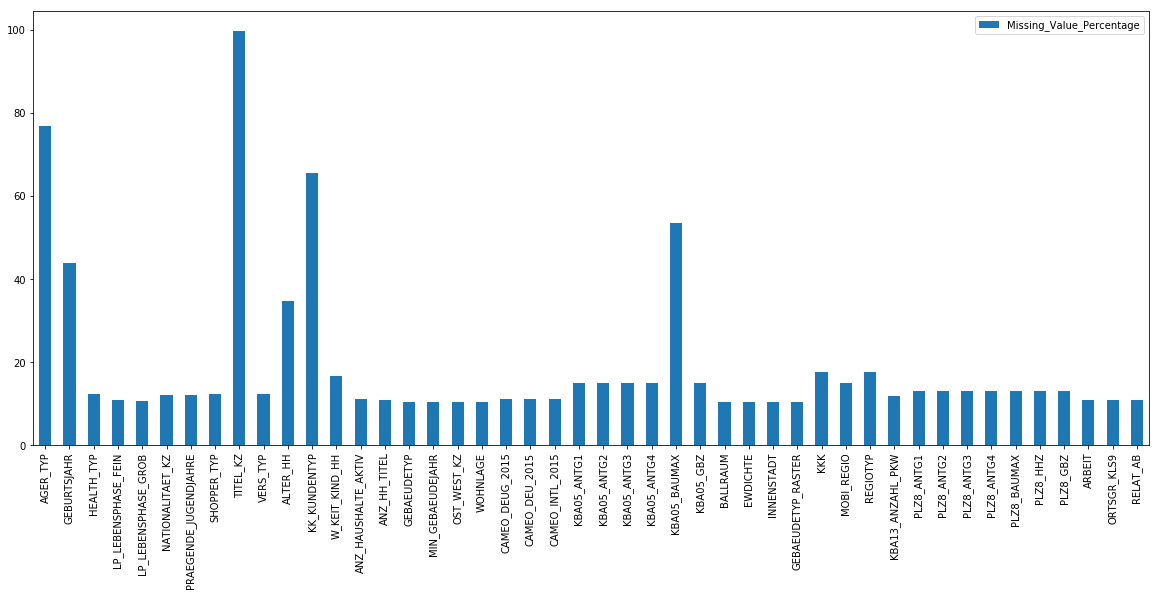

In [16]:
mvp2.plot(kind='bar',figsize =(20,8))
plt.show()

**Comment**

The above graph with attributes having more than 10% of the data missing includes 46 columns.

It clearly shows that `TITEL_KZ` with 99.7%, `AGER_TYP`with 76.9%, `KK_KUNDENTYP` with 65.6%, `KBA05_BAUMAX` with 53.4%, `GEBURTSJAHR`with 44.0% and `ALTER_HH`and 34.8% of the data missing are outliers. All of them have more than 20% of the data missing.

In [19]:
# Remove the outlier columns from the dataset. (You'll perform other data
# engineering tasks such as re-encoding and imputation later.)
outliers = mvp2[mvp2['Missing_Value_Percentage']>20.0]

new_azdias = azdias.drop(outliers.transpose(), axis=1)
new_azdias.head()

,ALTERSKATEGORIE_GROB,ANREDE_KZ,CJT_GESAMTTYP,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,FINANZTYP,...,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB
0,2.0,1.0,2.0,3.0,4.0,3.0,5.0,5.0,3.0,4.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1.0,2.0,5.0,1.0,5.0,2.0,5.0,4.0,5.0,1.0,...,2.0,3.0,2.0,1.0,1.0,5.0,4.0,3.0,5.0,4.0
2,3.0,2.0,3.0,1.0,4.0,1.0,2.0,3.0,5.0,1.0,...,3.0,3.0,1.0,0.0,1.0,4.0,4.0,3.0,5.0,2.0
3,4.0,2.0,2.0,4.0,2.0,5.0,2.0,1.0,2.0,6.0,...,2.0,2.0,2.0,0.0,1.0,3.0,4.0,2.0,3.0,3.0
4,3.0,1.0,5.0,4.0,3.0,4.0,1.0,3.0,2.0,5.0,...,2.0,4.0,2.0,1.0,2.0,3.0,3.0,4.0,6.0,5.0


In [20]:
for each in missed_val_percentage['Missing_Value_Percentage'].unique():
    display(missed_val_percentage[missed_val_percentage['Missing_Value_Percentage']==each])

,Missing_Value_Percentage
AGER_TYP,76.955435


,Missing_Value_Percentage
ALTERSKATEGORIE_GROB,0.323264


,Missing_Value_Percentage
ANREDE_KZ,0.0
FINANZ_MINIMALIST,0.0
FINANZ_SPARER,0.0
FINANZ_VORSORGER,0.0
FINANZ_ANLEGER,0.0
FINANZ_UNAUFFAELLIGER,0.0
FINANZ_HAUSBAUER,0.0
FINANZTYP,0.0
GREEN_AVANTGARDE,0.0
SEMIO_SOZ,0.0


,Missing_Value_Percentage
CJT_GESAMTTYP,0.544646
GFK_URLAUBERTYP,0.544646
LP_STATUS_FEIN,0.544646
LP_STATUS_GROB,0.544646
RETOURTYP_BK_S,0.544646
ONLINE_AFFINITAET,0.544646


,Missing_Value_Percentage
GEBURTSJAHR,44.020282


,Missing_Value_Percentage
HEALTH_TYP,12.476816
SHOPPER_TYP,12.476816
VERS_TYP,12.476816


,Missing_Value_Percentage
LP_LEBENSPHASE_FEIN,10.954859


,Missing_Value_Percentage
LP_LEBENSPHASE_GROB,10.611509


,Missing_Value_Percentage
LP_FAMILIE_FEIN,8.728699
LP_FAMILIE_GROB,8.728699


,Missing_Value_Percentage
NATIONALITAET_KZ,12.153551


,Missing_Value_Percentage
PRAEGENDE_JUGENDJAHRE,12.136608


,Missing_Value_Percentage
SOHO_KZ,8.247
ANZ_PERSONEN,8.247
ANZ_TITEL,8.247
WOHNDAUER_2008,8.247


,Missing_Value_Percentage
TITEL_KZ,99.757636


,Missing_Value_Percentage
ALTER_HH,34.813699


,Missing_Value_Percentage
HH_EINKOMMEN_SCORE,2.058749


,Missing_Value_Percentage
KK_KUNDENTYP,65.596749


,Missing_Value_Percentage
W_KEIT_KIND_HH,16.605084


,Missing_Value_Percentage
ANZ_HAUSHALTE_AKTIV,11.176913


,Missing_Value_Percentage
ANZ_HH_TITEL,10.884842


,Missing_Value_Percentage
GEBAEUDETYP,10.451729
MIN_GEBAEUDEJAHR,10.451729
OST_WEST_KZ,10.451729
WOHNLAGE,10.451729


,Missing_Value_Percentage
KONSUMNAEHE,8.299737


,Missing_Value_Percentage
CAMEO_DEUG_2015,11.147852
CAMEO_DEU_2015,11.147852
CAMEO_INTL_2015,11.147852


,Missing_Value_Percentage
KBA05_ANTG1,14.959701
KBA05_ANTG2,14.959701
KBA05_ANTG3,14.959701
KBA05_ANTG4,14.959701
KBA05_GBZ,14.959701
MOBI_REGIO,14.959701


,Missing_Value_Percentage
KBA05_BAUMAX,53.468668


,Missing_Value_Percentage
BALLRAUM,10.518154
EWDICHTE,10.518154
INNENSTADT,10.518154


,Missing_Value_Percentage
GEBAEUDETYP_RASTER,10.452514


,Missing_Value_Percentage
KKK,17.735668
REGIOTYP,17.735668


,Missing_Value_Percentage
KBA13_ANZAHL_PKW,11.871354


,Missing_Value_Percentage
PLZ8_ANTG1,13.073637
PLZ8_ANTG2,13.073637
PLZ8_ANTG3,13.073637
PLZ8_ANTG4,13.073637
PLZ8_BAUMAX,13.073637
PLZ8_HHZ,13.073637
PLZ8_GBZ,13.073637


,Missing_Value_Percentage
ARBEIT,10.926022
RELAT_AB,10.926022


,Missing_Value_Percentage
ORTSGR_KLS9,10.914689


#### Discussion 1.1.2: Assess Missing Data in Each Column

**Observations regarding the amount of missing data in each column.Which columns were removed from the dataset?**
There are 46 columns with more than 10% data missing. Out of the 46 columns, there are 6 columns which are outliers. 

`TITEL_KZ` with 99.7%, `AGER_TYP` with 76.9%, `KK_KUNDENTYP` with 65.6%, `KBA05_BAUMAX` with 53.4%, `GEBURTSJAHR` with 44.0% and `ALTER_HH` with 34.8% of the data missing are outliers. All of them have more than 20% of the data missing. This have been removed from the dataset. 

Now leaving the dataset with 79 columns. (from the previous 85)

**Are there any patterns in missing values?**
1. Group 1: `FINANZ_MINIMALIST`, `FINANZ_SPARER`, `FINANZ_VORSORGER`, `FINANZ_ANLEGER`, `FINANZ_UNAUFFAELLIGER`, `FINANZ_HAUSBAUER`, `FINANZTYP` all have no data missing. 
2. Group 2: `SEMIO_SOZ`, `SEMIO_FAM`, `SEMIO_REL`, `SEMIO_MAT`, `SEMIO_VERT`, `SEMIO_LUST`, `SEMIO_ERL`, `SEMIO_KULT`, `SEMIO_RAT`, `SEMIO_DOM`, `SEMIO_KAEM`, `SEMIO_PFLIGHT` and `SEMIO_TRADV` don't have any data missing either.
3. Group 3: `CJT_GESAMTTYP`, `GFP_URLAUBERTYP`, `LP_STATUS_FEIN`, `LP_STATUS_GROB`, `RETOURTYP_BK_S` and `ONLINE_AFFINITAET` all have 0.54% of missing data
4. Group 4: `HEALTH_TYP`, `SHOPPER_TYP` and `VERS_TYP` are missing 12.5% of data
5. Group 5: `LP_FAMILIE_FEIN` and `LP_FAMILIE_GROB` are all missing 8.72% of data
6. Group 6: `SOHO_KZ`, `ANZ_PERSONEN`, `ANZ_TITEL`, `WOHNDAUER_2008` are all missing 8.24% of data
7. Group 7: `CAMEO_DEUG_2015`, `CAMEO_DEU_2015`, `CAMEO_INTL_2015` are all missing 11.15% of data
8. Group 8: `KBA05_ANTG1`, `KBA05_ANTG2`, `KBA05_ANTG3`, `KBA05_ANTG4`, `KBA05_GBZ` and `MOBI_REGIO` are all missing 14.96% of data
9. Group 9: `BALLRAUM`, `EWDICHTE` and `INNENSTADT` missing 10.52% of data
10. Group 10: `KKK` and `REGIOTYP` missing 17.74% of data
11. Group 11: `PLZ8_ANTG1`, `PLZ8_ANTG2`, `PLZ8_ANTG3`, `PLZ8_ANTG4`, `PLZ8_BAUMAX1`, `PLZ8_HHZ` and `PLZ8_GBZ` all missing 13.07% of data
12. Group 12: `ARBEIT`, `RELAT_AB` missing 0.92% of data


Group 1, is all financial topology,  Group 2 is Personality topology, Group 3 is about consumer/shopping habbits and social status.

For the blocks that don't have any missing data are FINANZ, SEMIO, etc. which implies finacial situation, gender, etc. personal data which is available for everyone.


#### Step 1.1.3: Assess Missing Data in Each Row

Now, you'll perform a similar assessment for the rows of the dataset. How much data is missing in each row? As with the columns, you should see some groups of points that have a very different numbers of missing values. Divide the data into two subsets: one for data points that are above some threshold for missing values, and a second subset for points below that threshold.

In order to know what to do with the outlier rows, we should see if the distribution of data values on columns that are not missing data (or are missing very little data) are similar or different between the two groups. Select at least five of these columns and compare the distribution of values.
- You can use seaborn's [`countplot()`](https://seaborn.pydata.org/generated/seaborn.countplot.html) function to create a bar chart of code frequencies and matplotlib's [`subplot()`](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.subplot.html) function to put bar charts for the two subplots side by side.
- To reduce repeated code, you might want to write a function that can perform this comparison, taking as one of its arguments a column to be compared.

Depending on what you observe in your comparison, this will have implications on how you approach your conclusions later in the analysis. If the distributions of non-missing features look similar between the data with many missing values and the data with few or no missing values, then we could argue that simply dropping those points from the analysis won't present a major issue. On the other hand, if the data with many missing values looks very different from the data with few or no missing values, then we should make a note on those data as special. We'll revisit these data later on. **Either way, you should continue your analysis for now using just the subset of the data with few or no missing values.**

In [21]:
# How much data is missing in each row of the dataset?

missing_rows = pd.DataFrame(new_azdias.isnull().sum(axis=1), columns=["Missing_Rows"])
missing_rows.head()

,Missing_Rows
0,43
1,0
2,0
3,7
4,0


In [22]:
missing_rows.describe()

,Missing_Rows
count,891221.000000
mean,5.649894
std,13.234687
min,0.000000
25%,0.000000
50%,0.000000
75%,3.000000
max,49.000000


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fea2511f898>]], dtype=object)

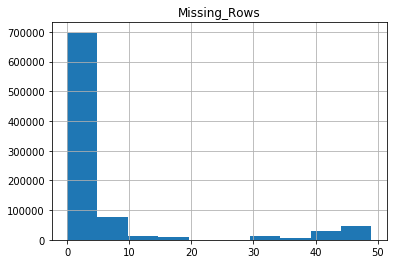

In [23]:
missing_rows.hist()

**Comment**
As the mean number of missing data in per row is 5, while 75% of the rows only have 3 missing values per row. Taking a split at >10 missing values per row as the split. 

In [24]:
azdias_rows = missing_rows.join(new_azdias)
azdias_rows.head()

,Missing_Rows,ALTERSKATEGORIE_GROB,ANREDE_KZ,CJT_GESAMTTYP,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,...,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB
0,43,2.0,1.0,2.0,3.0,4.0,3.0,5.0,5.0,3.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,0,1.0,2.0,5.0,1.0,5.0,2.0,5.0,4.0,5.0,...,2.0,3.0,2.0,1.0,1.0,5.0,4.0,3.0,5.0,4.0
2,0,3.0,2.0,3.0,1.0,4.0,1.0,2.0,3.0,5.0,...,3.0,3.0,1.0,0.0,1.0,4.0,4.0,3.0,5.0,2.0
3,7,4.0,2.0,2.0,4.0,2.0,5.0,2.0,1.0,2.0,...,2.0,2.0,2.0,0.0,1.0,3.0,4.0,2.0,3.0,3.0
4,0,3.0,1.0,5.0,4.0,3.0,4.0,1.0,3.0,2.0,...,2.0,4.0,2.0,1.0,2.0,3.0,3.0,4.0,6.0,5.0


In [25]:
# Write code to divide the data into two subsets based on the number of missing
# values in each row.
azdias_1 = pd.DataFrame(azdias_rows[azdias_rows["Missing_Rows"]<=10])
azdias_2 = pd.DataFrame(azdias_rows[azdias_rows["Missing_Rows"]>10])

#azdias_1.head()
azdias_2.head()

,Missing_Rows,ALTERSKATEGORIE_GROB,ANREDE_KZ,CJT_GESAMTTYP,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,...,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB
0,43,2.0,1.0,2.0,3.0,4.0,3.0,5.0,5.0,3.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
11,47,2.0,1.0,6.0,3.0,4.0,3.0,5.0,5.0,3.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
14,47,3.0,1.0,6.0,3.0,4.0,3.0,5.0,5.0,3.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
17,47,2.0,1.0,6.0,3.0,4.0,3.0,5.0,5.0,3.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
24,47,3.0,2.0,6.0,3.0,4.0,3.0,5.0,5.0,3.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fea24fc8278>]], dtype=object)

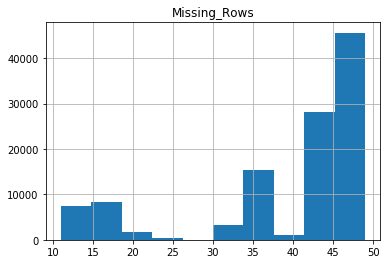

In [26]:
azdias_2.hist(column="Missing_Rows")

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fea24fafbe0>]], dtype=object)

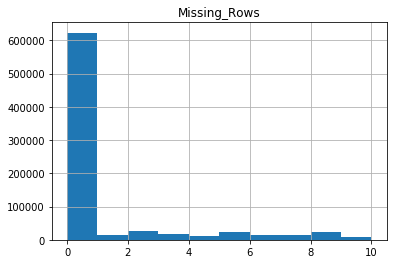

In [27]:
azdias_1.hist(column = "Missing_Rows")

In [28]:
def compare_missing_rows(df1, df2, column_name):
    figure, axis = plt.subplots(1, 2)
    sns.countplot(df1[column_name], ax=axis[0])
    sns.countplot(df2[column_name], ax=axis[1])
    figure.subplots_adjust(wspace = 1)
    figure.show()
    return

/opt/conda/lib/python3.6/site-packages/matplotlib/figure.py:418: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


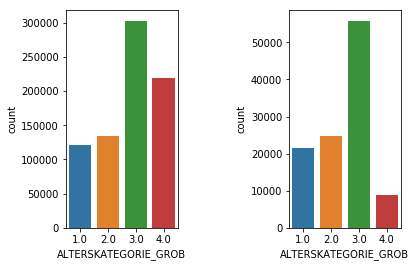

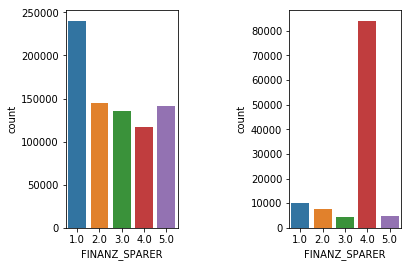

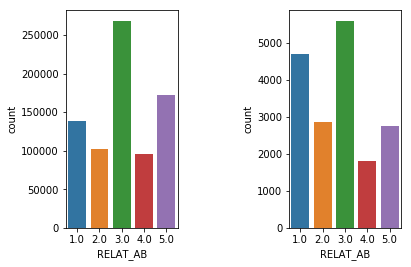

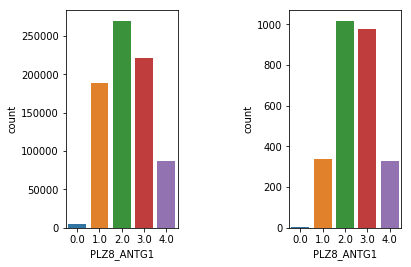

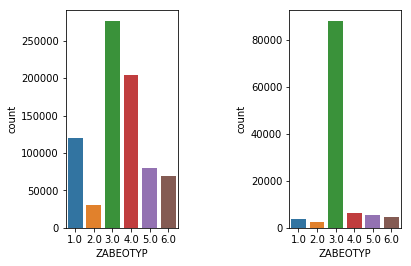

In [29]:
# Compare the distribution of values for at least five columns where there are
# no or few missing values, between the two subsets.

compare_missing_rows(azdias_1, azdias_2, 'ALTERSKATEGORIE_GROB')
compare_missing_rows(azdias_1, azdias_2, 'FINANZ_SPARER')
compare_missing_rows(azdias_1, azdias_2, 'RELAT_AB')
compare_missing_rows(azdias_1, azdias_2, 'PLZ8_ANTG1')
compare_missing_rows(azdias_1, azdias_2, 'ZABEOTYP')

In [30]:
#Dropping rows that have more than 10 columns of missing data.

azdias_new2 = azdias_rows[azdias_rows['Missing_Rows']<10]
azdias_new2.drop('Missing_Rows', axis=1, inplace=True)

azdias_new2.head()

/opt/conda/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


,ALTERSKATEGORIE_GROB,ANREDE_KZ,CJT_GESAMTTYP,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,FINANZTYP,...,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB
1,1.0,2.0,5.0,1.0,5.0,2.0,5.0,4.0,5.0,1.0,...,2.0,3.0,2.0,1.0,1.0,5.0,4.0,3.0,5.0,4.0
2,3.0,2.0,3.0,1.0,4.0,1.0,2.0,3.0,5.0,1.0,...,3.0,3.0,1.0,0.0,1.0,4.0,4.0,3.0,5.0,2.0
3,4.0,2.0,2.0,4.0,2.0,5.0,2.0,1.0,2.0,6.0,...,2.0,2.0,2.0,0.0,1.0,3.0,4.0,2.0,3.0,3.0
4,3.0,1.0,5.0,4.0,3.0,4.0,1.0,3.0,2.0,5.0,...,2.0,4.0,2.0,1.0,2.0,3.0,3.0,4.0,6.0,5.0
5,1.0,2.0,2.0,3.0,1.0,5.0,2.0,2.0,5.0,2.0,...,2.0,3.0,1.0,1.0,1.0,5.0,5.0,2.0,3.0,3.0


#### Discussion 1.1.3: Assess Missing Data in Each Row

**Reporting your observations regarding missing data in rows.**

From my observation, I can divide the data into a subset of missing more than 10 values per record and less than that. 

As the histograms for the two sections [>10 values missing, <=10 values missing per record] differ quite a bit, any record that is missing more than 10 values may create a bias in the data.

### Step 1.2: Select and Re-Encode Features

Checking for missing data isn't the only way in which you can prepare a dataset for analysis. Since the unsupervised learning techniques to be used will only work on data that is encoded numerically, you need to make a few encoding changes or additional assumptions to be able to make progress. In addition, while almost all of the values in the dataset are encoded using numbers, not all of them represent numeric values. Check the third column of the feature summary (`feat_info`) for a summary of types of measurement.
- For numeric and interval data, these features can be kept without changes.
- Most of the variables in the dataset are ordinal in nature. While ordinal values may technically be non-linear in spacing, make the simplifying assumption that the ordinal variables can be treated as being interval in nature (that is, kept without any changes).
- Special handling may be necessary for the remaining two variable types: categorical, and 'mixed'.

In the first two parts of this sub-step, you will perform an investigation of the categorical and mixed-type features and make a decision on each of them, whether you will keep, drop, or re-encode each. Then, in the last part, you will create a new data frame with only the selected and engineered columns.

Data wrangling is often the trickiest part of the data analysis process, and there's a lot of it to be done here. But stick with it: once you're done with this step, you'll be ready to get to the machine learning parts of the project!

In [31]:
#creating a clean version of feat_info not including the outlying columns previously deleted
feat_info_clean = feat_info[~feat_info['attribute'].isin(outliers.transpose().columns.tolist())]

In [32]:
# How many features are there of each data type?
feat_info_clean.groupby(['type'])['attribute'].count()

type
categorical    18
mixed           6
numeric         6
ordinal        49
Name: attribute, dtype: int64

#### Step 1.2.1: Re-Encode Categorical Features

For categorical data, you would ordinarily need to encode the levels as dummy variables. Depending on the number of categories, perform one of the following:
- For binary (two-level) categoricals that take numeric values, you can keep them without needing to do anything.
- There is one binary variable that takes on non-numeric values. For this one, you need to re-encode the values as numbers or create a dummy variable.
- For multi-level categoricals (three or more values), you can choose to encode the values using multiple dummy variables (e.g. via [OneHotEncoder](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.OneHotEncoder.html)), or (to keep things straightforward) just drop them from the analysis. As always, document your choices in the Discussion section.

In [33]:
# Assess categorical variables: which are binary, which are multi-level, and
# which one needs to be re-encoded?
categorical_features = feat_info_clean[feat_info_clean["type"]=="categorical"]["attribute"]
categorical_features

2            ANREDE_KZ
3        CJT_GESAMTTYP
10           FINANZTYP
12     GFK_URLAUBERTYP
13    GREEN_AVANTGARDE
17     LP_FAMILIE_FEIN
18     LP_FAMILIE_GROB
19      LP_STATUS_FEIN
20      LP_STATUS_GROB
21    NATIONALITAET_KZ
38         SHOPPER_TYP
39             SOHO_KZ
41            VERS_TYP
42            ZABEOTYP
52         GEBAEUDETYP
55         OST_WEST_KZ
57     CAMEO_DEUG_2015
58      CAMEO_DEU_2015
Name: attribute, dtype: object

In [34]:
#checking for binary/multilevel categorical features
binary_cat_feature=[]
multilevel_cat_feature=[]
for feature in categorical_features:
    if len(azdias_new2[feature].unique())==2:
        binary_cat_feature.append(feature)
    elif len(azdias_new2[feature].unique())>2:
        multilevel_cat_feature.append(feature)

In [35]:
print("Binary categorical features are: {}".format(binary_cat_feature))
print("Multilevel categorical features are: {}".format(multilevel_cat_feature))

Binary categorical features are: ['ANREDE_KZ', 'GREEN_AVANTGARDE', 'SOHO_KZ', 'OST_WEST_KZ']
Multilevel categorical features are: ['CJT_GESAMTTYP', 'FINANZTYP', 'GFK_URLAUBERTYP', 'LP_FAMILIE_FEIN', 'LP_FAMILIE_GROB', 'LP_STATUS_FEIN', 'LP_STATUS_GROB', 'NATIONALITAET_KZ', 'SHOPPER_TYP', 'VERS_TYP', 'ZABEOTYP', 'GEBAEUDETYP', 'CAMEO_DEUG_2015', 'CAMEO_DEU_2015']


In [36]:
for feature in binary_cat_feature:
    print("Feature: {} and Values: {}".format(feature, azdias_new2[feature].unique()))

Feature: ANREDE_KZ and Values: [ 2.  1.]
Feature: GREEN_AVANTGARDE and Values: [ 0.  1.]
Feature: SOHO_KZ and Values: [ 1.  0.]
Feature: OST_WEST_KZ and Values: ['W' 'O']


In [37]:
#re-encoding OST_WEST_KZ's character values to numeric:
azdias_new3 = azdias_new2.replace({'OST_WEST_KZ':{'W':0, 'O':1}})

In [38]:
# Re-encode categorical variable(s) to be kept in the analysis.
for feature in binary_cat_feature:
    print("Feature: {} and Values: {}".format(feature, azdias_new3[feature].unique()))

Feature: ANREDE_KZ and Values: [ 2.  1.]
Feature: GREEN_AVANTGARDE and Values: [ 0.  1.]
Feature: SOHO_KZ and Values: [ 1.  0.]
Feature: OST_WEST_KZ and Values: [0 1]


In [39]:
for feature in multilevel_cat_feature:
    value_counts = azdias_new3[feature].value_counts()
    print(feature)
    print('\n')
    print(value_counts)
    print('\n')


CJT_GESAMTTYP


4.0    193259
3.0    143473
2.0    139489
5.0    108693
6.0     98633
1.0     91196
Name: CJT_GESAMTTYP, dtype: int64


FINANZTYP


6.0    285195
1.0    191084
5.0    103849
2.0    101570
4.0     54679
3.0     38366
Name: FINANZTYP, dtype: int64


GFK_URLAUBERTYP


12.0    125144
10.0    101073
8.0      81762
11.0     73750
5.0      69722
4.0      60075
9.0      55536
3.0      52779
1.0      50031
7.0      39915
2.0      39522
6.0      25434
Name: GFK_URLAUBERTYP, dtype: int64


LP_FAMILIE_FEIN


1.0     394341
10.0    127067
2.0      96071
11.0     48192
8.0      21300
7.0      18661
4.0      11237
5.0      10970
9.0      10278
6.0       7753
3.0       4395
Name: LP_FAMILIE_FEIN, dtype: int64


LP_FAMILIE_GROB


1.0    394341
5.0    185537
2.0     96071
4.0     47714
3.0     26602
Name: LP_FAMILIE_GROB, dtype: int64


LP_STATUS_FEIN


1.0     204687
9.0     130838
2.0     109241
10.0    109217
4.0      73099
3.0      68324
6.0      28196
5.0      26187
8.0      15923
7

**Comment**

Knowing that I can drop all the multilevel features, I wanted to analyse them first. 
So, I'm now going through the definitions of the multilevel features:
- `CJT_GESAMTTYP`: preferred information and buying channels for consumer (includes details of consumption minimalist and traditionalist, store and online shoppers, and cross-channel types)
- `FINANZTYP`: Most descriptive financial type for individual (includes: low financial interest, money-saver, home ownership, be prepared, investor, inconspicuous)
- `GFK_URLAUBERTYP`: Vacation habits (includes various types of vacation)
- `LP_FAMILIE_FEIN`: Family type using a fine scale (distinguishes in age, whether partnered, and children age, and generational families)
- `LP_FAMILIE_GROB`: Family type using a broader scale (captures the above categories in broader definitions)
- `LP_STATUS_FEIN`: Social status using a fine scale (distinguishes between low and high income earners as well as some elements of living/work style)
- `LP_STATUS_GROB`: Socail status using a rough scale (captures the above categories in broader definitions)
- `NATIONALITAET_KZ`: Nationality based on given name analysis (includes categories of German-sounding, foreign-sounding, assimilated names)
- `SHOPPER_TYP`: Shopper typology (includes different kinds of shopper habits)
- `ZABEOTYP`: Energy consumption typology (includes categories of consumer decision making approach in considering 'green' alternatives)
- `GEBAEUDETYP`: Type of building
- `CAMEO_DEU_2015`: Wealth / Life Stage Typology using a fine scale (includes different descriptions of class)
- `CAMEO_DEUG_2015`: Wealth / Life Stage Typology using a broader scale (captures the above categories in broader definitions)

In considering the variables to keep, one also has to consider PCA. So, I decided to keep more encompassing features, broader family time, consumer status, etc.

The umbrella features (encompassing features)

**Consumer Type**
The features on consumer type are: `CJT_GESAMTTYP`, `SHOPPER_TYP`, `ZABEOTYP`.

Out of these I decided to include `CJT_GESAMTTYP`, as it showed similar information to that of `SHOPPER_TYP`.

**Family status**
The features on family type are: `LP_FAMILIE_FEIN`, `LP_FAMILIE_GROB`.
Out of these I decided to use the broader scale `LP_FAMILIE_GROB`.

**Financial Status***
The features on financial status are: `FINANZTYP`, `LP_STATUS_FEIN`, `LP_STATUS_GROB`, `CAMEO_DEU_2015`, `CAMEO_DUEG_2015`.
I decided to drop all of these multilevel features, as other features used are already capturing similar data.

**Others**
This leads to me to other features such as `GFP_URLAUBERTYP`, `NATIONALITAET_KZ`, `GEBAEUDETYP`.

I decided to keep all three of these features.


So finally, the multilevel features I'm keeping are: 
- `CJT_GESMTTYP`
- `LP_FAMILIE_GROB`
- `GFP_URLAUBERTYP`
- `NATIONALITAET_KZ`
- `GEBAEUDETYP`.

In [40]:
#drop excluded columns
drop_columns = ['LP_STATUS_FEIN', 'LP_STATUS_GROB', 'CAMEO_DEU_2015', 'CAMEO_DEUG_2015', 'FINANZTYP',  
                'SHOPPER_TYP', 'ZABEOTYP', 'LP_FAMILIE_FEIN']
azdias_new3.drop(drop_columns, axis=1, inplace=True)

In [41]:
#re-encoding
cat_keep = ['CJT_GESAMTTYP', 'LP_FAMILIE_GROB', 
            'GFK_URLAUBERTYP', 'NATIONALITAET_KZ', 'GEBAEUDETYP']
azdias_cat = azdias_new3[cat_keep]
azdias_not_cat = azdias_new3.drop(cat_keep, axis=1)

In [109]:
#imputing values in the kept columns
for feature in cat_keep:
    azdias_cat[feature].fillna(round(azdias_cat[feature].mean()), inplace=True)

/opt/conda/lib/python3.6/site-packages/pandas/core/generic.py:5434: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._update_inplace(new_data)


In [110]:
#one-hot encoding
enc = OneHotEncoder(handle_unknown='ignore')
azdias_encode_cat = enc.fit_transform(azdias_cat).toarray()

In [111]:
azdias_encode_cat.shape

(774743, 33)

In [143]:
cat_cols = ['CJT_GESAMTTYP_1', 'CJT_GESAMTTYP_2', 'CJT_GESAMTTYP_3', 
            'CJT_GESAMTTYP_4', 'CJT_GESAMTTYP_5', 'CJT_GESAMTTYP_6', 
            'LP_FAMILIE_GROB_1', 'LP_FAMILIE_GROB_2', 'LP_FAMILIE_GROB_3', 
            'LP_FAMILIE_GROB_4', 'LP_FAMILIE_GROB_5', 'GFK_URLAUBERTYP_1', 
            'GFK_URLAUBERTYP_2', 'GFK_URLAUBERTYP_3', 'GFK_URLAUBERTYP_4', 
            'GFK_URLAUBERTYP_5', 'GFK_URLAUBERTYP_6', 'GFK_URLAUBERTYP_7', 
            'GFK_URLAUBERTYP_8', 'GFK_URLAUBERTYP_9', 'GFK_URLAUBERTYP_10', 
            'GFK_URLAUBERTYP_11', 'GFK_URLAUBERTYP_12', 'NATIONALITAET_KZ_1', 
            'NATIONALITAET_KZ_2', 'NATIONALITAET_KZ_3', 'GEBAEUDETYP_1', 
            'GEBAEUDETYP_2', 'GEBAEUDETYP_3', 'GEBAEUDETYP_4', 'GEBAEUDETYP_5'
           ,'GEBAEUDETYP_6', 'GEBAEUDETYP_7']

In [144]:
azdias_new4 = azdias_not_cat.join(
    pd.DataFrame(azdias_encode_cat, azdias_not_cat.index, columns=cat_cols))
azdias_new4.head()

,ALTERSKATEGORIE_GROB,ANREDE_KZ,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,GREEN_AVANTGARDE,HEALTH_TYP,...,NATIONALITAET_KZ_1,NATIONALITAET_KZ_2,NATIONALITAET_KZ_3,GEBAEUDETYP_1,GEBAEUDETYP_2,GEBAEUDETYP_3,GEBAEUDETYP_4,GEBAEUDETYP_5,GEBAEUDETYP_6,GEBAEUDETYP_7
1,1.0,2.0,1.0,5.0,2.0,5.0,4.0,5.0,0.0,3.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
2,3.0,2.0,1.0,4.0,1.0,2.0,3.0,5.0,1.0,3.0,...,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
3,4.0,2.0,4.0,2.0,5.0,2.0,1.0,2.0,0.0,2.0,...,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
4,3.0,1.0,4.0,3.0,4.0,1.0,3.0,2.0,0.0,3.0,...,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
5,1.0,2.0,3.0,1.0,5.0,2.0,2.0,5.0,0.0,3.0,...,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0


#### Discussion 1.2.1: Re-Encode Categorical Features

All categorical features were identified using the cleaned dataframe (dropping columns and rows that were missing a lot of data). There were 18 categorical features, out of which 5 were binary and 13 were multi-level.

1 out of the five binary `OST_WEST_KZ` had string encoded values, they were re-encoded to numerical values `{'W':0, 'O':'1'}`

For the multilevel features, I've discussed the values I decided to keep and encode, and the are:
- `CJT_GESMTTYP`
- `LP_FAMILIE_GROB`
- `GFP_URLAUBERTYP`
- `NATIONALITAET_KZ`
- `GEBAEUDETYP`

These multilevel features were then imputed (with the mean value of each feature) and then encoded using OneHotEncoder.

#### Step 1.2.2: Engineer Mixed-Type Features

There are a handful of features that are marked as "mixed" in the feature summary that require special treatment in order to be included in the analysis. There are two in particular that deserve attention; the handling of the rest are up to your own choices:
- "PRAEGENDE_JUGENDJAHRE" combines information on three dimensions: generation by decade, movement (mainstream vs. avantgarde), and nation (east vs. west). While there aren't enough levels to disentangle east from west, you should create two new variables to capture the other two dimensions: an interval-type variable for decade, and a binary variable for movement.
- "CAMEO_INTL_2015" combines information on two axes: wealth and life stage. Break up the two-digit codes by their 'tens'-place and 'ones'-place digits into two new ordinal variables (which, for the purposes of this project, is equivalent to just treating them as their raw numeric values).
- If you decide to keep or engineer new features around the other mixed-type features, make sure you note your steps in the Discussion section.

Be sure to check `Data_Dictionary.md` for the details needed to finish these tasks.

### Investigate "PRAEGENDE_JUGENDJAHRE" and engineer two new variables.
On investigation PRAEGENDE_JUGENDJAHRE we find this:
Dominating movement of person's youth (avantgarde vs. mainstream; east vs. west)
- -1: unknown
-  0: unknown
-  1: 40s - war years (Mainstream, E+W)
-  2: 40s - reconstruction years (Avantgarde, E+W)
-  3: 50s - economic miracle (Mainstream, E+W)
-  4: 50s - milk bar / Individualisation (Avantgarde, E+W)
-  5: 60s - economic miracle (Mainstream, E+W)
-  6: 60s - generation 68 / student protestors (Avantgarde, W)
-  7: 60s - opponents to the building of the Wall (Avantgarde, E)
-  8: 70s - family orientation (Mainstream, E+W)
-  9: 70s - peace movement (Avantgarde, E+W)
- 10: 80s - Generation Golf (Mainstream, W)
- 11: 80s - ecological awareness (Avantgarde, W)
- 12: 80s - FDJ / communist party youth organisation (Mainstream, E)
- 13: 80s - Swords into ploughshares (Avantgarde, E)
- 14: 90s - digital media kids (Mainstream, E+W)
- 15: 90s - ecological awareness (Avantgarde, E+W)

In [147]:
mainstream_values = [1, 3, 5, 8, 10, 12, 14]
#mapping 0 to where it is Mainstream, and 1 to where it's avantgarde
azdias_new4['MAINSTREAM_AVANTGARDE'] = np.where(
    azdias_new4['PRAEGENDE_JUGENDJAHRE'].isin(mainstream_values), 0, 1)

In [148]:
#mapping decades
decade_list = {
    1: 1940, 2: 1940, 3: 1950, 4:1950, 5:1960, 
    6: 1960, 7: 1960, 8: 1970, 9:1970, 10:1980, 
    11:1980, 12:1980, 13:1980, 14:1990, 15:1990}

azdias_new4.replace({'PRAEGENDE_JUGENDJAHRE': decade_list}, inplace=True)
azdias_new4.rename(columns={'PRAEGENDE_JUGENDJAHRE': 'DECADE'}, inplace=True)

In [149]:
# Test
print(azdias_new4.DECADE.value_counts())
print(azdias_new4.MAINSTREAM_AVANTGARDE.value_counts())

1990.0    218377
1970.0    170842
1980.0    147224
1960.0    112362
1950.0     72943
1940.0     27493
Name: DECADE, dtype: int64
0    578772
1    195971
Name: MAINSTREAM_AVANTGARDE, dtype: int64


### Investigate "CAMEO_INTL_2015" and engineer two new variables.
German CAMEO: Wealth / Life Stage Typology, mapped to international code
- -1: unknown
- XX: unknown


- 11: Wealthy Households - Pre-Family Couples & Singles
- 12: Wealthy Households - Young Couples With Children
- 13: Wealthy Households - Families With School Age Children
- 14: Wealthy Households - Older Families &  Mature Couples
- 15: Wealthy Households - Elders In Retirement


- 21: Prosperous Households - Pre-Family Couples & Singles
- 22: Prosperous Households - Young Couples With Children
- 23: Prosperous Households - Families With School Age Children
- 24: Prosperous Households - Older Families & Mature Couples
- 25: Prosperous Households - Elders In Retirement


- 31: Comfortable Households - Pre-Family Couples & Singles
- 32: Comfortable Households - Young Couples With Children
- 33: Comfortable Households - Families With School Age Children
- 34: Comfortable Households - Older Families & Mature Couples
- 35: Comfortable Households - Elders In Retirement


- 41: Less Affluent Households - Pre-Family Couples & Singles
- 42: Less Affluent Households - Young Couples With Children
- 43: Less Affluent Households - Families With School Age Children
- 44: Less Affluent Households - Older Families & Mature Couples
- 45: Less Affluent Households - Elders In Retirement


- 51: Poorer Households - Pre-Family Couples & Singles
- 52: Poorer Households - Young Couples With Children
- 53: Poorer Households - Families With School Age Children
- 54: Poorer Households - Older Families & Mature Couples
- 55: Poorer Households - Elders In Retirement


Splitting between all of these values.

In [150]:
azdias_new4['CAMEO_INTL_2015'].isna().sum()

3456

In [151]:
for i in range(1,6):
    value_range = [i*10+x for x in range(1,6)]


In [152]:
azdias_new4.head()

,ALTERSKATEGORIE_GROB,ANREDE_KZ,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,GREEN_AVANTGARDE,HEALTH_TYP,...,NATIONALITAET_KZ_2,NATIONALITAET_KZ_3,GEBAEUDETYP_1,GEBAEUDETYP_2,GEBAEUDETYP_3,GEBAEUDETYP_4,GEBAEUDETYP_5,GEBAEUDETYP_6,GEBAEUDETYP_7,MAINSTREAM_AVANTGARDE
1,1.0,2.0,1.0,5.0,2.0,5.0,4.0,5.0,0.0,3.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0
2,3.0,2.0,1.0,4.0,1.0,2.0,3.0,5.0,1.0,3.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1
3,4.0,2.0,4.0,2.0,5.0,2.0,1.0,2.0,0.0,2.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0
4,3.0,1.0,4.0,3.0,4.0,1.0,3.0,2.0,0.0,3.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0
5,1.0,2.0,3.0,1.0,5.0,2.0,2.0,5.0,0.0,3.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0


In [153]:
#creating a wealth feature that maps
# 1: Wealthy
# 2: Posperous
# 3: Comfortable
# 4: Less Affluent
# 5: Poorer households
for i in range(1,6):
    value_range = [i*10.0+x for x in range(1,6)]
    azdias_new4.loc[azdias_new4['CAMEO_INTL_2015'].astype(float).isin(value_range), 'WEALTH']=i

#creating a family feature
# 1: Pre-Family & singles
# 2: Young Couples with children
# 3: Families with school age children
# 4: Older families & Mature couples
# 5: Elders in Retirement
for i in range(1,6):
    value_range = [x*10.0+i for x in range(1,6)]
    azdias_new4.loc[azdias_new4['CAMEO_INTL_2015'].astype(float).isin(value_range),'FAMILY_TYP']=i
    
azdias_new4.drop('CAMEO_INTL_2015', axis=1, inplace=True)    

In [154]:
#print(azdias_new4['CAMEO_INTL_2015'].value_counts())
print(azdias_new4['WEALTH'].value_counts())
print(azdias_new4['FAMILY_TYP'].value_counts())

5.0    220529
4.0    185971
2.0    183247
1.0    115911
3.0     65629
Name: WEALTH, dtype: int64
1.0    240237
4.0    226911
3.0    114588
5.0    114421
2.0     75130
Name: FAMILY_TYP, dtype: int64


Creating these features, makes a lot of features redundant such as:
- `W_KEIT_KIND_HH` has the likelihood of children in household
- `HH_EINKOMMEN_SCORE` estimated household net income
- `LP_LEBENSPHASE_GROB` estimates life stage/earnings
- `LP_LEBENSPHASE_FEIN` estimates life stage/earnings

So I'm dropping these features

In [155]:
azdias_new4.drop(['W_KEIT_KIND_HH', 'HH_EINKOMMEN_SCORE',
                 'LP_LEBENSPHASE_GROB', 'LP_LEBENSPHASE_FEIN'], 
                 axis=1, inplace=True)

In [156]:
azdias_new4.shape

(774743, 97)

#### Discussion 1.2.2: Engineer Mixed-Type Features

After engineering new features from the mixed value features, I've dropped `W_KEIT_KIND_HH` , `HH_EINKOMMEN_SCORE`, `LP_LEBENSPHASE_GROB`, `LP_LEBENSPHASE_FEIN` from the dataframe.

and created 4 new features `DECADE`, `MAINSTREAM_AVANTGARDE`, `WEALTH` and `FAMILY_TYP`

#### Step 1.2.3: Complete Feature Selection

In order to finish this step up, you need to make sure that your data frame now only has the columns that you want to keep. To summarize, the dataframe should consist of the following:
- All numeric, interval, and ordinal type columns from the original dataset.
- Binary categorical features (all numerically-encoded).
- Engineered features from other multi-level categorical features and mixed features.

Make sure that for any new columns that you have engineered, that you've excluded the original columns from the final dataset. Otherwise, their values will interfere with the analysis later on the project. For example, you should not keep "PRAEGENDE_JUGENDJAHRE", since its values won't be useful for the algorithm: only the values derived from it in the engineered features you created should be retained. As a reminder, your data should only be from **the subset with few or no missing values**.

In [56]:
# If there are other re-engineering tasks you need to perform, make sure you
# take care of them here. (Dealing with missing data will come in step 2.1.)



In [57]:
# Do whatever you need to in order to ensure that the dataframe only contains
# the columns that should be passed to the algorithm functions.



### Step 1.3: Create a Cleaning Function

Even though you've finished cleaning up the general population demographics data, it's important to look ahead to the future and realize that you'll need to perform the same cleaning steps on the customer demographics data. In this substep, complete the function below to execute the main feature selection, encoding, and re-engineering steps you performed above. Then, when it comes to looking at the customer data in Step 3, you can just run this function on that DataFrame to get the trimmed dataset in a single step.

In [157]:
def clean_data(df, enc):
    """
    Perform feature trimming, re-encoding, and engineering for demographics
    data
    
    INPUT: Demographics DataFrame
    OUTPUT: Trimmed and cleaned demographics DataFrame
    """
    
    #convert NaNs coded values
    #creating a dictionary of all NaN values
    replace_dict = {}
    for attribute, each in zip(feat_info['attribute'], feat_info['missing_or_unknown']):
        nan_str_value = each.strip('[]').split(",")
        nan_value=[]
        for value in nan_str_value:
            if(value.isnumeric() or value.lstrip('-').isnumeric()):
                nan_value.append(int(value))
            else:
                nan_value.append(value)
        replace_dict.update({attribute: nan_value})

    # Put in code here to execute all main cleaning steps:
    # convert missing value codes into NaNs, ...
    print("Replacing all Missing values with NaN...")
    df.replace(replace_dict, np.nan, inplace=True)
    
    #Dropping columns 
    
    print("Dropping columns with missing information...")
    drop_columns = ['AGER_TYP', 'GEBURTSJAHR', 'TITEL_KZ', 'ALTER_HH', 
                    'KK_KUNDENTYP', 'KBA05_BAUMAX', 'LP_STATUS_FEIN', 
                    'LP_STATUS_GROB', 'CAMEO_DEU_2015', 'CAMEO_DEUG_2015', 
                    'FINANZTYP', 'SHOPPER_TYP', 'ZABEOTYP', 
                    'LP_FAMILIE_FEIN', 'W_KEIT_KIND_HH', 
                    'HH_EINKOMMEN_SCORE', 'LP_LEBENSPHASE_GROB', 
                    'LP_LEBENSPHASE_FEIN']
    
    # remove selected columns and rows, ...
    df.drop(drop_columns, axis=1, inplace=True)
    
    missing_rows = pd.DataFrame(df.isnull().sum(axis=1), columns=["Missing_Rows"])
    df_missing = missing_rows.join(df)
    df = df_missing[df_missing["Missing_Rows"]<10]
    df.drop("Missing_Rows", axis=1, inplace=True)
    
    
    
    # select, re-encode, and engineer column values.
    ## encoding for OST_WEST_KZ
    print("Re-encoding column values...")
    df.replace({'OST_WEST_KZ': {'W':0, 'O':1}}, inplace=True)
    
    ##multilevel value encoding for categorical columns
    cat_keep = ['CJT_GESAMTTYP', 'LP_FAMILIE_GROB', 
                'GFK_URLAUBERTYP', 'NATIONALITAET_KZ', 'GEBAEUDETYP']
    

    #imputing before encoding data
    print("Imputing certain columns before re-encoding...")
    for feature in cat_keep:
        df[feature].fillna(round(df[feature].mean()), inplace=True)  
    
    df_cat = df[cat_keep]
    df_not_cat = df.drop(cat_keep, axis=1)
    
    cat_cols = ['CJT_GESAMTTYP_1', 'CJT_GESAMTTYP_2', 'CJT_GESAMTTYP_3', 
            'CJT_GESAMTTYP_4', 'CJT_GESAMTTYP_5', 'CJT_GESAMTTYP_6', 
            'LP_FAMILIE_GROB_1', 'LP_FAMILIE_GROB_2', 'LP_FAMILIE_GROB_3', 
            'LP_FAMILIE_GROB_4', 'LP_FAMILIE_GROB_5', 'GFK_URLAUBERTYP_1', 
            'GFK_URLAUBERTYP_2', 'GFK_URLAUBERTYP_3', 'GFK_URLAUBERTYP_4', 
            'GFK_URLAUBERTYP_5', 'GFK_URLAUBERTYP_6', 'GFK_URLAUBERTYP_7', 
            'GFK_URLAUBERTYP_8', 'GFK_URLAUBERTYP_9', 'GFK_URLAUBERTYP_10', 
            'GFK_URLAUBERTYP_11', 'GFK_URLAUBERTYP_12', 'NATIONALITAET_KZ_1', 
            'NATIONALITAET_KZ_2', 'NATIONALITAET_KZ_3', 'GEBAEUDETYP_1', 
            'GEBAEUDETYP_2', 'GEBAEUDETYP_3', 'GEBAEUDETYP_4', 'GEBAEUDETYP_5'
           ,'GEBAEUDETYP_6', 'GEBAEUDETYP_7']
    
    cat_array = enc.transform(df_cat).toarray()
    
    df = df_not_cat.join(pd.DataFrame(
            cat_array, df_not_cat.index, columns=cat_cols))
    
    ##Re-engineering new columns on existing features.
    ###PRAEGENDE_JUGENDJAHRE
    mainstream_values = [1, 3, 5, 8, 10, 12, 14]
    df['MAINSTREAM_AVANTGARDE'] = np.where(
        df['PRAEGENDE_JUGENDJAHRE'].isin(mainstream_values), 0, 1)
    
    decade_list = {
        1: 1940, 2: 1940, 3: 1950, 4:1950, 5:1960, 
        6: 1960, 7: 1960, 8: 1970, 9:1970, 10:1980, 
        11:1980, 12:1980, 13:1980, 14:1990, 15:1990}

    df.replace({'PRAEGENDE_JUGENDJAHRE': decade_list}, inplace=True)
    df.rename(columns={'PRAEGENDE_JUGENDJAHRE': 'DECADE'}, inplace=True)
    
    ###CAMEO_INTL_2015
    
    for i in range(1,6):
        value_range = [i*10.0+x for x in range(1,6)]
        df.loc[df['CAMEO_INTL_2015'].astype(float).isin(value_range), 
                        'WEALTH']=i
    
    for i in range(1,6):
        value_range = [x*10.0+i for x in range(1,6)]
        df.loc[df['CAMEO_INTL_2015'].astype(float).isin(value_range),
                        'FAMILY_TYP']=i
    
    df.drop('CAMEO_INTL_2015', axis=1, inplace=True)

    # Return the cleaned dataframe.
    print("Returning clean data...")
    return df
    

In [158]:
azdias_new4.shape

(774743, 97)

## Step 2: Feature Transformation

### Step 2.1: Apply Feature Scaling

Before we apply dimensionality reduction techniques to the data, we need to perform feature scaling so that the principal component vectors are not influenced by the natural differences in scale for features. Starting from this part of the project, you'll want to keep an eye on the [API reference page for sklearn](http://scikit-learn.org/stable/modules/classes.html) to help you navigate to all of the classes and functions that you'll need. In this substep, you'll need to check the following:

- sklearn requires that data not have missing values in order for its estimators to work properly. So, before applying the scaler to your data, make sure that you've cleaned the DataFrame of the remaining missing values. This can be as simple as just removing all data points with missing data, or applying an [Imputer](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.Imputer.html) to replace all missing values. You might also try a more complicated procedure where you temporarily remove missing values in order to compute the scaling parameters before re-introducing those missing values and applying imputation. Think about how much missing data you have and what possible effects each approach might have on your analysis, and justify your decision in the discussion section below.
- For the actual scaling function, a [StandardScaler](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html) instance is suggested, scaling each feature to mean 0 and standard deviation 1.
- For these classes, you can make use of the `.fit_transform()` method to both fit a procedure to the data as well as apply the transformation to the data at the same time. Don't forget to keep the fit sklearn objects handy, since you'll be applying them to the customer demographics data towards the end of the project.

In [159]:
# If you've not yet cleaned the dataset of all NaN values, then investigate and
# do that now.

azdias_new4.isnull().sum().sum()

437462

In [160]:
# Apply feature scaling to the general population demographics data.
scaler = StandardScaler()
scaler.fit(azdias_new4.dropna()) 
#dropping all nan values for fitting
imputer = Imputer()
azdias_imputed = imputer.fit_transform(azdias_new4) 
#imputing mean for missing values
azdias_std = scaler.fit_transform(azdias_imputed)


In [161]:
azdias_clean = pd.DataFrame(azdias_std, columns=list(azdias_new4))

In [162]:
azdias_clean.head()

,ALTERSKATEGORIE_GROB,ANREDE_KZ,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,GREEN_AVANTGARDE,HEALTH_TYP,...,GEBAEUDETYP_1,GEBAEUDETYP_2,GEBAEUDETYP_3,GEBAEUDETYP_4,GEBAEUDETYP_5,GEBAEUDETYP_6,GEBAEUDETYP_7,MAINSTREAM_AVANTGARDE,WEALTH,FAMILY_TYP
0,-1.765007,0.958422,-1.488785,1.540017,-1.044684,1.468541,0.981043,1.327209,-0.531136,1.077799,...,-1.159135,-0.074655,-0.53939,-0.032331,-0.001136,-0.026605,2.038109,-0.581892,1.179748,-1.259894
1,0.199492,0.958422,-1.488785,0.867244,-1.770775,-0.568811,0.263375,1.327209,1.882757,1.077799,...,0.862712,-0.074655,-0.53939,-0.032331,-0.001136,-0.026605,-0.490651,1.718533,-0.871766,0.760743
2,1.181742,0.958422,0.689233,-0.478302,1.133590,-0.568811,-1.171961,-0.818216,-0.531136,-0.276069,...,0.862712,-0.074655,-0.53939,-0.032331,-0.001136,-0.026605,-0.490651,-0.581892,-1.555604,-0.586348
3,0.199492,-1.043381,0.689233,0.194471,0.407498,-1.247929,0.263375,-0.818216,-0.531136,1.077799,...,0.862712,-0.074655,-0.53939,-0.032331,-0.001136,-0.026605,-0.490651,-0.581892,0.495910,0.087197
4,-1.765007,0.958422,-0.036773,-1.151076,1.133590,-0.568811,-0.454293,1.327209,-0.531136,1.077799,...,0.862712,-0.074655,-0.53939,-0.032331,-0.001136,-0.026605,-0.490651,-0.581892,1.179748,0.760743


In [163]:
azdias_clean.isnull().sum().sum()

0

### Discussion 2.1: Apply Feature Scaling

I replaced all the missing values in the columns using the `Imputer` method. This replaces all the missing values with the mean values. 

I then scaled it using `StandardScaler` method. StandardScaler scales in such a way that all values are in a column would be distributed such that their mean is 0 and standard deviation is 1. This is done because there are features which have higher magnitudes, and higher variance among them. These high variance features can dominate the model, thus resulting in an incorrect model. StandardScaler is used to prevent the high variance features to dominate over the entire model.

StandardScaler is also recommended when working on a classification problem, as we will be classifying the data into different segments later. I decided to use StandardScaler for scaling the data.

Reference: https://medium.com/@contactsunny/why-do-we-need-feature-scaling-in-machine-learning-and-how-to-do-it-using-scikit-learn-d8314206fe73

### Step 2.2: Perform Dimensionality Reduction

On your scaled data, you are now ready to apply dimensionality reduction techniques.

- Use sklearn's [PCA](http://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html) class to apply principal component analysis on the data, thus finding the vectors of maximal variance in the data. To start, you should not set any parameters (so all components are computed) or set a number of components that is at least half the number of features (so there's enough features to see the general trend in variability).
- Check out the ratio of variance explained by each principal component as well as the cumulative variance explained. Try plotting the cumulative or sequential values using matplotlib's [`plot()`](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.plot.html) function. Based on what you find, select a value for the number of transformed features you'll retain for the clustering part of the project.
- Once you've made a choice for the number of components to keep, make sure you re-fit a PCA instance to perform the decided-on transformation.

In [165]:
# Apply PCA to the data.
pca = PCA()
pca.fit(azdias_clean)

PCA(copy=True, iterated_power='auto', n_components=None, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False)

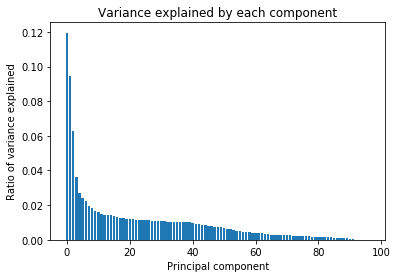

In [183]:
# Investigate the variance accounted for by each principal component.
plt.bar(range(len(pca.explained_variance_ratio_)), pca.explained_variance_ratio_)
plt.title("Variance explained by each component")
plt.xlabel("Principal component")
plt.ylabel("Ratio of variance explained")
plt.show()


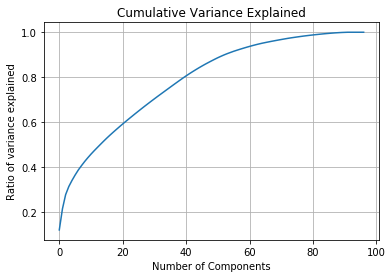

In [184]:
plt.plot(range(len(pca.explained_variance_ratio_)),np.cumsum(pca.explained_variance_ratio_), '-')
plt.title("Cumulative Variance Explained")
plt.xlabel("Number of Components")
plt.ylabel("Ratio of variance explained")
plt.grid()
plt.show()

In [166]:
# Re-apply PCA to the data while selecting for number of components to retain.
pca_40 = PCA(n_components=40)
azdias_pca = pca_40.fit_transform(azdias_clean)

### Discussion 2.2: Perform Dimensionality Reduction

I decided to retain 40 principal components, as it explains >80% of the variance. Reducing the number of features by more than 50%.

### Step 2.3: Interpret Principal Components

Now that we have our transformed principal components, it's a nice idea to check out the weight of each variable on the first few components to see if they can be interpreted in some fashion.

As a reminder, each principal component is a unit vector that points in the direction of highest variance (after accounting for the variance captured by earlier principal components). The further a weight is from zero, the more the principal component is in the direction of the corresponding feature. If two features have large weights of the same sign (both positive or both negative), then increases in one tend expect to be associated with increases in the other. To contrast, features with different signs can be expected to show a negative correlation: increases in one variable should result in a decrease in the other.

- To investigate the features, you should map each weight to their corresponding feature name, then sort the features according to weight. The most interesting features for each principal component, then, will be those at the beginning and end of the sorted list. Use the data dictionary document to help you understand these most prominent features, their relationships, and what a positive or negative value on the principal component might indicate.
- You should investigate and interpret feature associations from the first three principal components in this substep. To help facilitate this, you should write a function that you can call at any time to print the sorted list of feature weights, for the *i*-th principal component. This might come in handy in the next step of the project, when you interpret the tendencies of the discovered clusters.

In [185]:
# Map weights for the first principal component to corresponding feature names
# and then print the linked values, sorted by weight.
# HINT: Try defining a function here or in a new cell that you can reuse in the
# other cells.

df = pd.DataFrame(pca.components_[0])
df.index = azdias_clean.columns
df.columns = ['PC_1']
df_1_top = df.sort_index(by=['PC_1'], ascending=False)[:10]
df_1_bottom = df.sort_index(by=['PC_1'])[:10]
print(df_1_top)
print(df_1_bottom)

                      PC_1
PLZ8_ANTG3        0.220413
PLZ8_ANTG4        0.216467
PLZ8_BAUMAX       0.212621
ORTSGR_KLS9       0.197081
EWDICHTE          0.194740
WEALTH            0.191785
PLZ8_ANTG2        0.148511
KBA05_ANTG4       0.148232
FINANZ_HAUSBAUER  0.148063
FINANZ_SPARER     0.141018
                        PC_1
MOBI_REGIO         -0.229092
PLZ8_ANTG1         -0.219580
KBA05_ANTG1        -0.211854
FINANZ_MINIMALIST  -0.205397
KBA05_GBZ          -0.205145
KONSUMNAEHE        -0.167371
INNENSTADT         -0.164400
PLZ8_GBZ           -0.163008
BALLRAUM           -0.128728
GEBAEUDETYP_RASTER -0.122212


/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: by argument to sort_index is deprecated, please use .sort_values(by=...)
  if __name__ == '__main__':
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:10: FutureWarning: by argument to sort_index is deprecated, please use .sort_values(by=...)
  # Remove the CWD from sys.path while we load stuff.


In [186]:
# Map weights for the second principal component to corresponding feature names
# and then print the linked values, sorted by weight.

df = pd.DataFrame(pca.components_[1])
df.index = azdias_clean.columns
df.columns = ['PC_2']
df_2_top = df.sort_index(by=['PC_2'], ascending=False)[:10]
df_2_bottom = df.sort_index(by=['PC_2'])[:10]
print(df_2_top)
print(df_2_bottom)

                          PC_2
ALTERSKATEGORIE_GROB  0.250570
FINANZ_VORSORGER      0.224118
SEMIO_ERL             0.215109
SEMIO_LUST            0.176949
RETOURTYP_BK_S        0.161975
CJT_GESAMTTYP_2       0.114399
FINANZ_HAUSBAUER      0.111508
SEMIO_KRIT            0.104421
SEMIO_KAEM            0.099601
PLZ8_ANTG3            0.096153
                           PC_2
DECADE                -0.244291
SEMIO_REL             -0.241555
FINANZ_SPARER         -0.228724
SEMIO_TRADV           -0.221832
SEMIO_PFLICHT         -0.221284
FINANZ_UNAUFFAELLIGER -0.218976
FINANZ_ANLEGER        -0.205150
SEMIO_KULT            -0.204527
SEMIO_FAM             -0.168140
SEMIO_RAT             -0.167852


/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:7: FutureWarning: by argument to sort_index is deprecated, please use .sort_values(by=...)
  import sys
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:8: FutureWarning: by argument to sort_index is deprecated, please use .sort_values(by=...)
  


In [187]:
# Map weights for the third principal component to corresponding feature names
# and then print the linked values, sorted by weight.

df = pd.DataFrame(pca.components_[2])
df.index = azdias_clean.columns
df.columns = ['PC_3']
df_3_top = df.sort_index(by=['PC_3'], ascending=False)[:10]
df_3_bottom = df.sort_index(by=['PC_3'])[:10]
print(df_3_top)
print(df_3_bottom)

                          PC_3
SEMIO_VERT            0.349000
SEMIO_SOZ             0.265430
SEMIO_FAM             0.255221
SEMIO_KULT            0.241068
FINANZ_MINIMALIST     0.158406
RETOURTYP_BK_S        0.102070
FINANZ_VORSORGER      0.090552
SEMIO_REL             0.078753
ALTERSKATEGORIE_GROB  0.070605
SEMIO_MAT             0.060115
                           PC_3
ANREDE_KZ             -0.371664
SEMIO_KAEM            -0.341608
SEMIO_DOM             -0.315156
SEMIO_KRIT            -0.278903
SEMIO_RAT             -0.210953
SEMIO_ERL             -0.182521
FINANZ_ANLEGER        -0.179802
FINANZ_SPARER         -0.097035
DECADE                -0.096419
FINANZ_UNAUFFAELLIGER -0.088959


/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:7: FutureWarning: by argument to sort_index is deprecated, please use .sort_values(by=...)
  import sys
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:8: FutureWarning: by argument to sort_index is deprecated, please use .sort_values(by=...)
  


### Discussion 2.3: Interpret Principal Components

(Double-click this cell and replace this text with your own text, reporting your observations from detailed investigation of the first few principal components generated. Can we interpret positive and negative values from them in a meaningful way?)

***FIRST DIMENSION***

`PLZ8_ANTG3`, `PLZ8_ANTG4`, `PLZ8_BAUMAX`, `ORTSGR_KLS9`, `EWDICHTE`, `WEALTH`, `PLZ8_ANTG2`, `KBA05_ANTG4`, `FINANZ_HAUSBAUER`, `FINANZ_SPARER` have the top positive correlations. All of these features are strongly related to home ownership. PLZ8_ANTG* describe the number of homes the family owns in the PLZ region. FINANZ_HAUSBAUER implies home owner. Then comes WEALTH and FINANZ_SPARER that are related the the financial status, and money saving habits of the family.

`MOBI_REGIO`, `PLZ8_ANTG1`, `KBA05_ANTG1`, `FINANZ_MINIMALIST`, `KBA05_GBZ`, `KONSUMNAEHE`, `INNENSTADT`, `PLZ8_GBZ`, `BALLRAUM`, `GEBAEUDETYP_RASTER` have the top lowest correlations. MOBI_REGIO is movement patterns, FINANZ_MINIMALIST is about low financial interest,  and distance to sales/nearest urban center. This creates a sense of high movement, less interest in wealth management and lower home ownership in the family.

From this, one can understand that the first dimension is about Wealth and Home Ownership.

***SECOND DIMENSION***

`ALTERSKATEGORIE_GROB`, `FINANZ_VORSORGER`, `SEMIO_ERL`, `SEMIO_LUST`,` RETOURTYP_BK_S`, `CJT_GESAMTTYP_2`, `FINANZ_HAUSBAUER`, `SEMIO_KRIT`, `SEMIO_KAEM`, `PLZ8_ANTG3` have high correlation in the second dimension. These all describe the personality of the shopper, age, customer-type, SEMIO* being attitude, etc. Most of the attitudes described are: event-oriented, sensual, critical-minded, combative attitude, etc.

`DECADE`, `SEMIO_REL`, `FINANZ_SPARER`, `SEMIO_TRADV`, `SEMIO_PFLICHT`, `FINANZ_UNAUFFAELLIGER`, `FINANZ_ANLEGER`, `SEMIO_KULT`, `SEMIO_FAM`, `SEMIO_RAT` the attitudes marked here are religious, traditional, dutiful, financially inconspicuos, or financial investor. These points towards an older demographic, while the positive correlation points towards a person of younger demogrphic.


***THIRD DIMENSION***

`SEMIO_VERT`, `SEMIO_SOZ`, `SEMIO_FAM`, `SEMIO_KULT`, `FINANZ_MINIMALIST`, `RETOURTYP_BK_S`, `FINANZ_VORSORGER`, `SEMIO_REL`, `ALTERSKATEGORIE_GROB`, `SEMIO_MAT` are higly positively correlated. Personality topology highly ranked here is dreamful, socially-minded, family-minded, cultural-minded, religious, materialistic. Financially minimalist/be prepared.

`ANREDE_KZ`, `SEMIO_KAEM`, `SEMIO_DOM`, `SEMIO_KRIT`, `SEMIO_RAT`, `SEMIO_ERL`, `FINANZ_ANLEGER`, `FINANZ_SPARER`, `DECADE`, `FINANZ_UNAUFFAELLIGER` are negatively correlated. Financially money-saver/inconspicous/investor, decade they were born. Personality correlated to combative, dominant-minded, critical-minded, rational, event-oriented are also negatively correlated.

## Step 3: Clustering

### Step 3.1: Apply Clustering to General Population

You've assessed and cleaned the demographics data, then scaled and transformed them. Now, it's time to see how the data clusters in the principal components space. In this substep, you will apply k-means clustering to the dataset and use the average within-cluster distances from each point to their assigned cluster's centroid to decide on a number of clusters to keep.

- Use sklearn's [KMeans](http://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html#sklearn.cluster.KMeans) class to perform k-means clustering on the PCA-transformed data.
- Then, compute the average difference from each point to its assigned cluster's center. **Hint**: The KMeans object's `.score()` method might be useful here, but note that in sklearn, scores tend to be defined so that larger is better. Try applying it to a small, toy dataset, or use an internet search to help your understanding.
- Perform the above two steps for a number of different cluster counts. You can then see how the average distance decreases with an increasing number of clusters. However, each additional cluster provides a smaller net benefit. Use this fact to select a final number of clusters in which to group the data. **Warning**: because of the large size of the dataset, it can take a long time for the algorithm to resolve. The more clusters to fit, the longer the algorithm will take. You should test for cluster counts through at least 10 clusters to get the full picture, but you shouldn't need to test for a number of clusters above about 30.
- Once you've selected a final number of clusters to use, re-fit a KMeans instance to perform the clustering operation. Make sure that you also obtain the cluster assignments for the general demographics data, since you'll be using them in the final Step 3.3.

In [188]:
def kmeans_score(data, center):
    '''
    returns kmeans score for the number of clusters/centers
    INPUT:
        data - the dataset used to fit kmeans
        center - the number of centers/clusters to fit kmeans (n_clusters)
    OUTPUT:
        the score for the given kmeans model
    '''
    # run k-means clustering on the data and...
    kmeans = KMeans(n_clusters=center)
    model = kmeans.fit(data)
    # compute the average within-cluster distances.
    score = np.abs(model.score(data))
    
    return score

In [189]:
data = pd.DataFrame(azdias_pca).sample(frac=0.5, random_state=42)
data.shape

(387372, 40)

Fitting data with 1 clusters
Fitting data with 2 clusters
Fitting data with 3 clusters
Fitting data with 4 clusters
Fitting data with 5 clusters
Fitting data with 6 clusters
Fitting data with 7 clusters
Fitting data with 8 clusters
Fitting data with 9 clusters
Fitting data with 10 clusters
Fitting data with 11 clusters
Fitting data with 12 clusters
Fitting data with 13 clusters
Fitting data with 14 clusters
Fitting data with 15 clusters
Fitting data with 16 clusters
Fitting data with 17 clusters
Fitting data with 18 clusters
Fitting data with 19 clusters


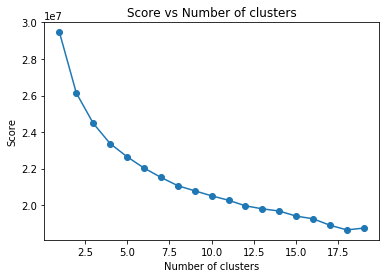

In [77]:
# Over a number of different cluster counts...
scores = []
centers = list(range(1,20))

#reducing the dataset to test on
data = pd.DataFrame(azdias_pca).sample(frac=0.5, random_state=42)

for center in centers:
    print("Fitting data with {} clusters".format(center))
    scores.append(kmeans_score(data ,center))


# Investigate the change in within-cluster distance across number of clusters.
# HINT: Use matplotlib's plot function to visualize this relationship.
plt.plot(centers, scores, marker='o');
plt.xlabel('Number of clusters');
plt.ylabel('Score');
plt.title('Score vs Number of clusters')
plt.show()   
    

In [190]:
# Re-fit the k-means model with the selected number of clusters and obtain
# cluster predictions for the general population demographics data.

kmeans_8 = KMeans(n_clusters=8)
model_8 = kmeans_8.fit(pd.DataFrame(azdias_pca))

azdias_clusters = model_8.predict(pd.DataFrame(azdias_pca))

### Discussion 3.1: Apply Clustering to General Population

(Double-click this cell and replace this text with your own text, reporting your findings and decisions regarding clustering. Into how many clusters have you decided to segment the population?)

Using the elbow method on 50% of the data (randomised). 
I think, the  last big jump in the score is for k=8 clusters (i.e. the elbow).


This is why I've re-fit the kmeans model with value k=8 for the whole dataset.

### Step 3.2: Apply All Steps to the Customer Data

Now that you have clusters and cluster centers for the general population, it's time to see how the customer data maps on to those clusters. Take care to not confuse this for re-fitting all of the models to the customer data. Instead, you're going to use the fits from the general population to clean, transform, and cluster the customer data. In the last step of the project, you will interpret how the general population fits apply to the customer data.

- Don't forget when loading in the customers data, that it is semicolon (`;`) delimited.
- Apply the same feature wrangling, selection, and engineering steps to the customer demographics using the `clean_data()` function you created earlier. (You can assume that the customer demographics data has similar meaning behind missing data patterns as the general demographics data.)
- Use the sklearn objects from the general demographics data, and apply their transformations to the customers data. That is, you should not be using a `.fit()` or `.fit_transform()` method to re-fit the old objects, nor should you be creating new sklearn objects! Carry the data through the feature scaling, PCA, and clustering steps, obtaining cluster assignments for all of the data in the customer demographics data.

In [222]:
# Load in the customer demographics data.
customers = pd.read_csv('Udacity_CUSTOMERS_Subset.csv', delimiter=';')

In [223]:
customers.head()

,AGER_TYP,ALTERSKATEGORIE_GROB,ANREDE_KZ,CJT_GESAMTTYP,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,...,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB
0,2,4,1,5.0,5,1,5,1,2,2,...,3.0,3.0,1.0,0.0,1.0,5.0,5.0,1.0,2.0,1.0
1,-1,4,1,NaN,5,1,5,1,3,2,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,-1,4,2,2.0,5,1,5,1,4,4,...,2.0,3.0,3.0,1.0,3.0,3.0,2.0,3.0,5.0,3.0
3,1,4,1,2.0,5,1,5,2,1,2,...,3.0,2.0,1.0,0.0,1.0,3.0,4.0,1.0,3.0,1.0
4,-1,3,1,6.0,3,1,4,4,5,2,...,2.0,4.0,2.0,1.0,2.0,3.0,3.0,3.0,5.0,1.0


In [224]:
# Apply preprocessing, feature transformation, and clustering from the general
# demographics onto the customer data, obtaining cluster predictions for the
# customer demographics data.

#cleaning the data
customers_clean = clean_data(customers, enc)

Replacing all Missing values with NaN...
Dropping columns with missing information...


/opt/conda/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)
/opt/conda/lib/python3.6/site-packages/pandas/core/generic.py:5821: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  regex=regex)
/opt/conda/lib/python3.6/site-packages/pandas/core/generic.py:5434: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._update_inplace(new_data)


Re-encoding column values...
Imputing certain columns before re-encoding...
Returning clean data...


In [200]:
customers_clean.isnull().sum().sum()

66508

In [201]:
customers_clean.head()

,ALTERSKATEGORIE_GROB,ANREDE_KZ,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,GREEN_AVANTGARDE,HEALTH_TYP,...,GEBAEUDETYP_1,GEBAEUDETYP_2,GEBAEUDETYP_3,GEBAEUDETYP_4,GEBAEUDETYP_5,GEBAEUDETYP_6,GEBAEUDETYP_7,MAINSTREAM_AVANTGARDE,WEALTH,FAMILY_TYP
0,4.0,1,5,1,5,1,2,2,1,1.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1,1.0,3.0
2,4.0,2,5,1,5,1,4,4,1,2.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1,3.0,4.0
3,4.0,1,5,1,5,2,1,2,0,2.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0,2.0,4.0
4,3.0,1,3,1,4,4,5,2,0,3.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0,4.0,1.0
5,3.0,1,5,1,5,1,2,3,1,3.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1,3.0,4.0


In [202]:
#imputing missing data
customers_clean = imputer.transform(customers_clean)

In [203]:
#feature scaling
customers_std = scaler.transform(customers_clean)

In [204]:
#dimensionality reduction
customers_pca = pca_40.transform(customers_std)

### Step 3.3: Compare Customer Data to Demographics Data

At this point, you have clustered data based on demographics of the general population of Germany, and seen how the customer data for a mail-order sales company maps onto those demographic clusters. In this final substep, you will compare the two cluster distributions to see where the strongest customer base for the company is.

Consider the proportion of persons in each cluster for the general population, and the proportions for the customers. If we think the company's customer base to be universal, then the cluster assignment proportions should be fairly similar between the two. If there are only particular segments of the population that are interested in the company's products, then we should see a mismatch from one to the other. If there is a higher proportion of persons in a cluster for the customer data compared to the general population (e.g. 5% of persons are assigned to a cluster for the general population, but 15% of the customer data is closest to that cluster's centroid) then that suggests the people in that cluster to be a target audience for the company. On the other hand, the proportion of the data in a cluster being larger in the general population than the customer data (e.g. only 2% of customers closest to a population centroid that captures 6% of the data) suggests that group of persons to be outside of the target demographics.

Take a look at the following points in this step:

- Compute the proportion of data points in each cluster for the general population and the customer data. Visualizations will be useful here: both for the individual dataset proportions, but also to visualize the ratios in cluster representation between groups. Seaborn's [`countplot()`](https://seaborn.pydata.org/generated/seaborn.countplot.html) or [`barplot()`](https://seaborn.pydata.org/generated/seaborn.barplot.html) function could be handy.
  - Recall the analysis you performed in step 1.1.3 of the project, where you separated out certain data points from the dataset if they had more than a specified threshold of missing values. If you found that this group was qualitatively different from the main bulk of the data, you should treat this as an additional data cluster in this analysis. Make sure that you account for the number of data points in this subset, for both the general population and customer datasets, when making your computations!
- Which cluster or clusters are overrepresented in the customer dataset compared to the general population? Select at least one such cluster and infer what kind of people might be represented by that cluster. Use the principal component interpretations from step 2.3 or look at additional components to help you make this inference. Alternatively, you can use the `.inverse_transform()` method of the PCA and StandardScaler objects to transform centroids back to the original data space and interpret the retrieved values directly.
- Perform a similar investigation for the underrepresented clusters. Which cluster or clusters are underrepresented in the customer dataset compared to the general population, and what kinds of people are typified by these clusters?

In [205]:
#predicting labels of data:
customers_clusters = pd.DataFrame(model_8.predict((customers_pca)), 
                                  columns=['Predictions'])
azdias_clusters = pd.DataFrame(azdias_clusters, columns=['Predictions'])

In [206]:
len(customers_clusters)

139549

In [207]:
# Compare the proportion of data in each cluster for the customer data to the
# proportion of data in each cluster for the general population.
customers_dist = 100*customers_clusters.groupby('Predictions').size() \
                    /len(customers_clusters)
azdias_dist = 100*azdias_clusters.groupby('Predictions').size() \
                /len(azdias_clusters)

print(customers_dist)
print(azdias_dist)

Predictions
0     1.075608
1    19.538657
2     3.260503
3     0.944471
4     1.989265
5    50.186673
6    10.462275
7    12.542548
dtype: float64
Predictions
0    10.582090
1    16.469591
2     9.955430
3     8.435701
4    11.943186
5    16.570527
6    13.282340
7    12.761135
dtype: float64


In [208]:
data = pd.concat([customers_dist, azdias_dist], axis=1)
data.columns=["customer", "azdias"]
data

,customer,azdias
Predictions,,
0,1.075608,10.582090
1,19.538657,16.469591
2,3.260503,9.955430
3,0.944471,8.435701
4,1.989265,11.943186
5,50.186673,16.570527
6,10.462275,13.282340
7,12.542548,12.761135


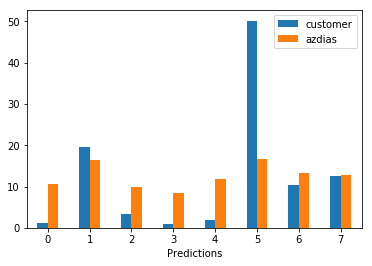

In [209]:
ax = data.plot.bar(rot=0)

In [210]:
# What kinds of people are part of a cluster that is overrepresented in the
# customer data compared to the general population?

over=[]
under=[]
index=0
for cust, azd in zip(customers_dist, azdias_dist):
    if(cust>azd):
        over.append(index)
    else:
        under.append(index)
    index += 1
print("Overrepresented data for customers over general is in labels:{}".format(over))
print("Underrepresented data for customers over general is in labels:{}".format(under))

Overrepresented data for customers over general is in labels:[1, 5]
Underrepresented data for customers over general is in labels:[0, 2, 3, 4, 6, 7]


In [231]:
centroid_1 = scaler.inverse_transform(pca_40.inverse_transform(model_8.cluster_centers_[1]))
centroid_5 = scaler.inverse_transform(pca_40.inverse_transform(model_8.cluster_centers_[5]))
over_c = pd.DataFrame([centroid_1, centroid_5], columns=customers_clean.columns)

In [258]:
over_c[['DECADE']]

,DECADE
0,1965.399195
1,1964.417931


#### What kinds of people are over represented?
From the above graph, one can see that label 1, and label 5 are over-represented. 

Now finding the centroid for these two labels. I can see certain matching characteristics that make the target customers. Here are some of my observations below:
- `ALTERSAKTEGORIE_GROB` is ~3 implying that the target customer is 46-60 years old.
- `FINANZ_SPARER` is between 1-2 implying that the person is a finacially a money-saver. `FINANZ_ANLEGER` ~2 implying investor and inconspiciuous due to `FINANZ_ANAUFFAELLIGER`.
- As `WEALTH` is ~2 this implies the target customers are well off. 
- As `FAMILY_TYP` is ~3 this implies the family with children.
- `SEMIO_TRADV` is ~3 implying high affinity towards a traditional-minded personality.
- `WOHNDAUER_2008` is ~8 implying length of residence 7-10 years. `MOBI_REGIO` is 4 implying low movement
- `BALLRAUM` is ~5 implying the nearest urban center is 40-50km away
- `KKK` is ~2 implying heigh purchasing power in the region.
- `ONLINE_AFFINITAET` is ~2 implying middle-high online affinity. 
- `REGIO_TYP` is ~4 implying middle class
- `PLZ_BAUMAX` is ~1 implying 1-2 family homes in the region.

In [228]:
# What kinds of people are part of a cluster that is underrepresented in the
# customer data compared to the general population?
centroid_0 = scaler.inverse_transform(pca_40.inverse_transform(model_8.cluster_centers_[0]))
centroid_2 = scaler.inverse_transform(pca_40.inverse_transform(model_8.cluster_centers_[2]))
centroid_3 = scaler.inverse_transform(pca_40.inverse_transform(model_8.cluster_centers_[3]))
centroid_4 = scaler.inverse_transform(pca_40.inverse_transform(model_8.cluster_centers_[4]))
centroid_6 = scaler.inverse_transform(pca_40.inverse_transform(model_8.cluster_centers_[6]))
centroid_7 = scaler.inverse_transform(pca_40.inverse_transform(model_8.cluster_centers_[7]))
under_c = pd.DataFrame([centroid_0, centroid_2, centroid_3, centroid_4, centroid_6, centroid_7],
                      columns=customers_clean.columns)

In [257]:
under_c[['DECADE']]

,DECADE
0,1985.260635
1,1986.081011
2,1986.577044
3,1985.749220
4,1963.693612
5,1964.296210


#### What kinds of people are underrepresented?

From the above graph, one can see that label 0, 1, 3, 4 and 5 are under-represented.

Now finding the centroid for these labels. I can see certain matching characteristics that make the target customers. Here are some of my observations below:

- `SEMIO_TRADV` >3 low affinity for traditional minded.
- `ALTERSKATEGORIE_GROB` are mostly <3 implying ages under 46 years.
- `ANDREDE_KZ` is >1 implying females
- `FINANZ_SPARER` is mostly ~4, implying low tendancy to be a money saver. `FINANZ_MINIMALIST` is <3 implying low financial interest.
- `REGIO_TYP` is ~5 implying lower middle class
- `WEALTH` is ~4/2 implying less propesporous families/very wealthy families
- `PLZ_BAUMAX` is 2-3 implies 3-10 family homes in the PLZ8 region.
- `MOBI_REGIO` is <3 implying high-medium movement pattern. 
- `KKK` is closer to 3 implying average purchasing power in the region
- `ONLINE-AFFINITAET` is mostly <3 implying middle-low online affinity.



### Discussion 3.3: Compare Customer Data to Demographics Data

(Double-click this cell and replace this text with your own text, reporting findings and conclusions from the clustering analysis. Can we describe segments of the population that are relatively popular with the mail-order company, or relatively unpopular with the company?)

From the above steps one can find that the mailing company has the following target audience:
- Low movement or long residents of a certain area.
- Possibly male
- 46-60 year old people, whose youth was in ~1965.
- Are financially savers/investors.
- Have a high purchasing power, and are of financially well-off families.

> Congratulations on making it this far in the project! Before you finish, make sure to check through the entire notebook from top to bottom to make sure that your analysis follows a logical flow and all of your findings are documented in **Discussion** cells. Once you've checked over all of your work, you should export the notebook as an HTML document to submit for evaluation. You can do this from the menu, navigating to **File -> Download as -> HTML (.html)**. You will submit both that document and this notebook for your project submission.